In [58]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from resizeimage import resizeimage
%matplotlib inline
# tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
ls ../data

README.md        pets/            train_label.txt  zipcode/


# Step 0: load the data

## Labels

In [167]:
with open("../data/pets/train_label.txt") as file:
    labels = file.read()

In [168]:
labels = [label[1:-1] for label in labels.split("\n")][:-1]

In [170]:
len(labels)

2000

## Training images

In [2]:
filenames = [file for file in glob.glob("../data/pets/train/*")]

In [3]:
filenames.sort(key=lambda x: int(x[22:-4]))

In [171]:
labels = [1 if label == "cat" else 0 for label in labels]

In [16]:
images = [plt.imread(filename) for filename in filenames]

In [73]:
dimensions = pd.DataFrame(data={"height": [image.shape[0] for image in images], 
                                "width": [image.shape[1] for image in images]})

In [74]:
dimensions["ratio"] = dimensions["width"]/dimensions["height"]

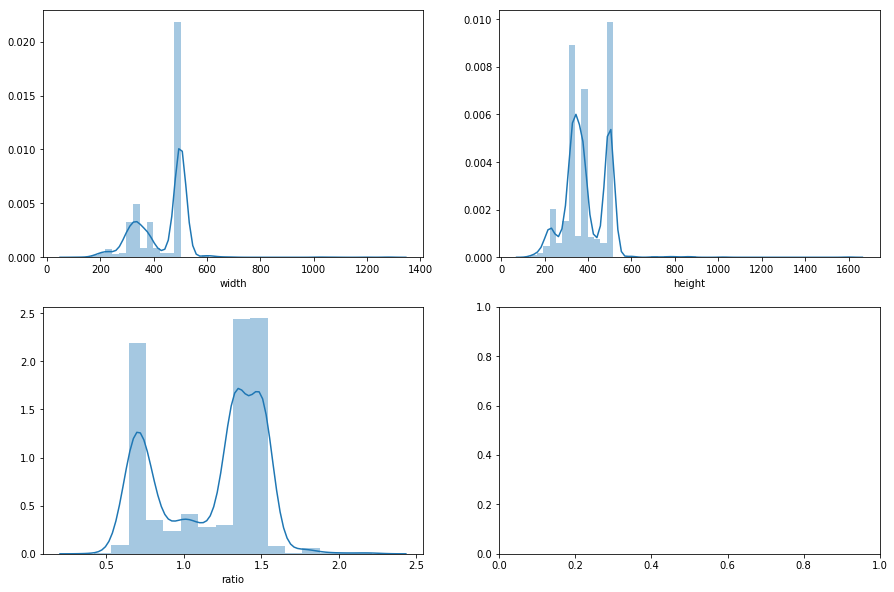

In [75]:
fig, axs = plt.subplots(2, 2, figsize = (15,10))

sns.distplot(dimensions["width"], ax=axs[0,0])
sns.distplot(dimensions["height"], ax=axs[0,1])
sns.distplot(dimensions["ratio"], ax=axs[1,0])

We can see that we have two main clusters, which correspond to "landscape" and "portrait" images... We will try to crop all images to square and hope not to disturb too much

In [105]:
len(dimensions[dimensions["ratio"] < 1])

653

In [101]:
dimensions["width"].median(), dimensions["height"].median(), dimensions["ratio"].median()

(500.0, 375.0, 1.3333333333333333)

In [37]:
dimensions["ratio"]

,height,width,ratio
0,500,375,0.750000
1,500,333,0.666000
2,500,375,0.750000
3,334,500,1.497006
4,300,500,1.666667


In [94]:
print(dimensions["ratio"].min())
print(dimensions["ratio"].quantile(0.1))
print(dimensions["ratio"].quantile(0.9))
print(dimensions["ratio"].max())

0.42
0.666
1.5015015015015014
2.2123893805309733


In [66]:
from PIL import Image

In [72]:
Image.fromarray(images[0]).size

(500, 375)

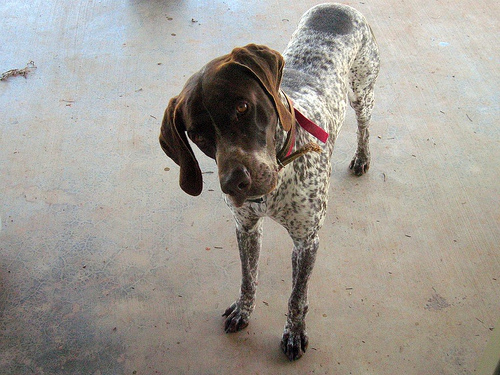

In [70]:
resizeimage.resize_crop(Image.fromarray(images[0]), [500,375])

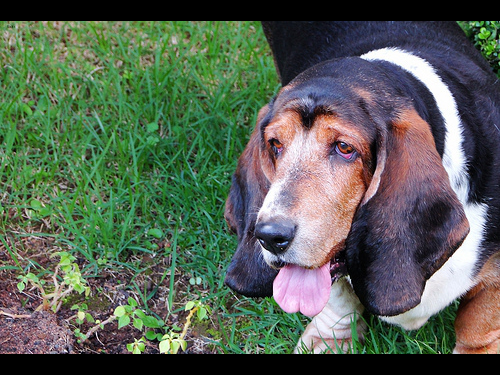

In [79]:
resizeimage.resize_crop(Image.fromarray(images[1]), [500,375])

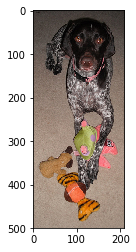

In [87]:
dimensions["ratio"].min()
plt.imshow(images[dimensions["ratio"].idxmin()]);

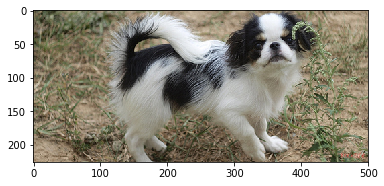

In [88]:
dimensions["ratio"].max()
plt.imshow(images[dimensions["ratio"].idxmax()]);

# Resizing

## Step 1: make all images square (this it not optimal)

In [115]:
squared_images = list()
for image in images:
    image = Image.fromarray(image)
    new_shape = (min(image.size),) * 2
    image = resizeimage.resize_crop(image, new_shape)
    squared_images.append(image)

## Step 2: resize images

Since anyway we need small images for the neural net, for now we resize images to be the size of the smallest image (114x114). We'll need to change this of course, in particular the test set might have even smaller images and the function we use to resize cannot interpolate to resize to bigger images.

In [124]:
min([image.size for image in squared_images])

(114, 114)

In [134]:
resized_images = [resizeimage.resize_height(image, 113) for image in squared_images]

## Step 3: put all this in a matrix

In [135]:
len(resized_images)

2000

In [150]:
flattened_images = [np.array(image.getdata(), np.uint8).flatten() for image in resized_images]

In [236]:
X = np.array(flattened_images)

In [237]:
X.shape

(2000, 38307)

38307 = 113 x 113 x 3

## Step 4: split dataset

In [239]:
y = tf.keras.utils.to_categorical(labels) # one hot for 2 classes

In [240]:
y.shape

(2000, 2)

In [207]:
from sklearn.model_selection import train_test_split

In [241]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [243]:
X_train.shape, y_train.shape

((1600, 38307), (1600, 2))

## Step 5: train Neural Net

In [210]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(

In [249]:
layers = tf.keras.layers # built-in keras from tensorflow
models = tf.keras.models

model = models.Sequential()
model.add(layers.Reshape((113, 113, 3), input_shape=(38307,)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(113, 113, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [250]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='mse',
              metrics=['accuracy'])

In [251]:
model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
1600/1600 [==============================]1600/1600 [==============================] - 66s 41ms/step - loss: 0.3450 - acc: 0.6506

Epoch 2/10
1600/1600 [==============================]1600/1600 [==============================] - 59s 37ms/step - loss: 0.3325 - acc: 0.6675

Epoch 3/10
1600/1600 [==============================]1600/1600 [==============================] - 59s 37ms/step - loss: 0.3325 - acc: 0.6675

Epoch 4/10
1600/1600 [==============================]1600/1600 [==============================] - 59s 37ms/step - loss: 0.3325 - acc: 0.6675

Epoch 5/10
1600/1600 [==============================]1600/1600 [==============================] - 59s 37ms/step - loss: 0.3325 - acc: 0.6675

Epoch 6/10
1600/1600 [==============================]1600/1600 [==============================] - 57s 35ms/step - loss: 0.3325 - acc: 0.6675

Epoch 7/10
1600/1600 [==============================]1600/1600 [==============================] - 59s 37ms/step - loss: 0.3325 - acc: 0.6675

Epoch 